<a href="https://colab.research.google.com/github/DanielVeraDrop/BDP_Base-de-Datos/blob/main/examples/vision/ipynb/video_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This example is a follow-up to the
[Video Classification with a CNN-RNN Architecture](https://keras.io/examples/vision/video_classification/)
example. This time, we will be using a Transformer-based model
([Vaswani et al.](https://arxiv.org/abs/1706.03762)) to classify videos. You can follow
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11)
in case you need an introduction to Transformers (with code). After reading this
example, you will know how to develop hybrid Transformer-based models for video
classification that operate on CNN feature maps.

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

ERROR: Operation cancelled by user


## Data collection

As done in the [predecessor](https://keras.io/examples/vision/video_classification/) to
this example, we will be using a subsampled version of the
[UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php),
a well-known benchmark dataset. In case you want to operate on a larger subsample or
even the entire dataset, please refer to
[this notebook](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb).

In [2]:
!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar -xf ucf101_top5.tar.gz

## Setup

In [6]:
import os
import keras
from keras import layers
from keras.applications.densenet import DenseNet121

from tensorflow_docs.vis import embed

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2

## Parametros

In [4]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

## Data preparation
* We reduce the image size to 128x128 instead of 224x224 to speed up computation.
* Instead of using a pre-trained [InceptionV3](https://arxiv.org/abs/1512.00567) network,
we use a pre-trained
[DenseNet121](http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf)
for feature extraction.
* We directly pad shorter videos to length `MAX_SEQ_LENGTH`.

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = keras.ops.convert_to_numpy(cropped)
    cropped = keras.ops.squeeze(cropped)
    return cropped

def load_video(path, max_frames=0, offload_to_cpu=False):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = frame[:, :, [2, 1, 0]]
            frame = crop_center(frame)
            if offload_to_cpu and keras.backend.backend() == "torch":
                frame = frame.to("cpu")
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    if offload_to_cpu and keras.backend.backend() == "torch":
        return np.array([frame.to("cpu").numpy() for frame in frames])
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


Total videos for training: 594
Total videos for testing: 224
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Calling `prepare_all_videos()` on `train_df` and `test_df` takes ~20 minutes to
complete. For this reason, to save time, here we download already preprocessed NumPy arrays:

In [8]:
!!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!!tar -xf top5_data_prepared.tar.gz

[]

In [49]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


## Building the Transformer-based model

We will be building on top of the code shared in
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11) of
[Deep Learning with Python (Second ed.)](https://www.manning.com/books/deep-learning-with-python)
by François Chollet.

First, self-attention layers that form the basic blocks of a Transformer are
order-agnostic. Since videos are ordered sequences of frames, we need our
Transformer model to take into account order information.
We do this via **positional encoding**.
We simply embed the positions of the frames present inside videos with an
[`Embedding` layer](https://keras.io/api/layers/core_layers/embedding). We then
add these positional embeddings to the precomputed CNN feature maps.

In [50]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embeddings.build(input_shape)

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        inputs = keras.ops.cast(inputs, self.compute_dtype)
        length = keras.ops.shape(inputs)[1]
        positions = keras.ops.arange(start=0, stop=length, step=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions


Now, we can create a subclassed layer for the Transformer.

In [51]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation=keras.activations.gelu),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


## Utility functions for training

In [52]:

def get_compiled_model(shape):
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=shape)
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model(train_data.shape[1:])
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model


## Model training and inference

In [53]:
trained_model = run_experiment()

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5973 - loss: 2.0151
Epoch 1: val_loss improved from inf to 1.47141, saving model to /tmp/video_classifier.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 410ms/step - accuracy: 0.6067 - loss: 1.9673 - val_accuracy: 0.4222 - val_loss: 1.4714
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9602 - loss: 0.1240
Epoch 2: val_loss improved from 1.47141 to 1.36051, saving model to /tmp/video_classifier.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9610 - loss: 0.1206 - val_accuracy: 0.7000 - val_loss: 1.3605
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9940 - loss: 0.0145
Epoch 3: val_loss did not improve from 1.36051
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9937 - loss: 0.0150 - val_accuracy: 0.5444 - val_loss: 2.1431
Epoch 4/5
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9928 - loss: 0.0146
Epoch 4: val_loss did not improve from 1.36051
16/16 ━━━━━━━━━━━━━━━

**Note**: This model has ~4.23 Million parameters, which is way more than the sequence
model (99918 parameters) we used in the prequel of this example.  This kind of
Transformer model works best with a larger dataset and a longer pre-training schedule.

Test video path: v_TennisSwing_g05_c02.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
  CricketShot: 99.48%
  TennisSwing:  0.52%
  ShavingBeard:  0.00%
  Punch:  0.00%
  PlayingCello:  0.00%


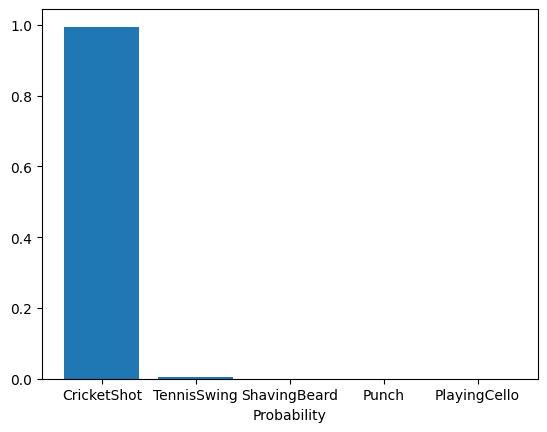


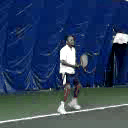

In [44]:

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path), offload_to_cpu=True)
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    plot_x_axis, plot_y_axis = [], []

    for i in np.argsort(probabilities)[::-1]:
        plot_x_axis.append(class_vocab[i])
        plot_y_axis.append(probabilities[i])
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    plt.bar(plot_x_axis, plot_y_axis, label=plot_x_axis)
    plt.xlabel("class_label")
    plt.xlabel("Probability")
    plt.show()

    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
  PlayingCello: 33.80%
  Punch: 29.78%
  CricketShot: 29.14%
  TennisSwing:  7.26%
  ShavingBeard:  0.03%


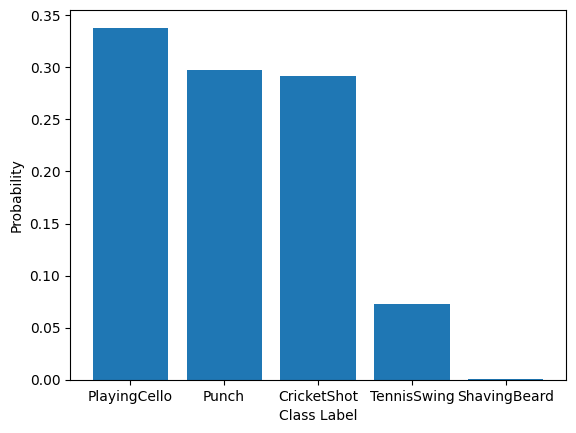

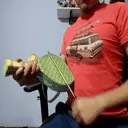

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf

# Función para preprocesar un solo video
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Rellenar videos más cortos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate([frames, padding])

    frames = frames[None, ...]

    # Extraer características de los fotogramas del video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features

# Función para predecir la acción del video
def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    # Cargar el video
    frames = load_video(path)
    frame_features = prepare_single_video(frames)

    # Predecir con el modelo entrenado
    probabilities = trained_model.predict(frame_features)[0]

    # Mostrar las probabilidades por clase
    plot_x_axis, plot_y_axis = [], []

    for i in np.argsort(probabilities)[::-1]:
        plot_x_axis.append(class_vocab[i])
        plot_y_axis.append(probabilities[i])
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    plt.bar(plot_x_axis, plot_y_axis, label=plot_x_axis)
    plt.xlabel("Class Label")
    plt.ylabel("Probability")
    plt.show()

    return frames

# Cargar y procesar tu video personalizado
video_path = "Violin_1.mp4" #(Barba o Golpe o Violin)
test_frames = predict_action(video_path)

# Mostrar el video como animación GIF (opcional)
def to_gif(images):
    import imageio
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    from IPython.display import Image
    return Image(open("animation.gif", "rb").read())

to_gif(test_frames[:MAX_SEQ_LENGTH])

In [15]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [35]:
!ffmpeg -i Violin.mp4 -vf "scale=128:128,fps=20" -t 1 Violin_1.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab